In [1]:
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from collections import defaultdict

# ============================================================
# 🔧 Helper: Extract PPO parameters from filename
# ============================================================
def extract_ppo_params(fn):
    """Extract PPO parameters from filename for legend labels."""
    c = re.search(r"clip_param=([\d\.]+)", fn)
    kl = re.search(r"target_kl=([\d\.]+)", fn)
    pi = re.search(r"train_policy_iters=(\d+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    return f"clip={c.group(1) if c else '?'}, kl={kl.group(1) if kl else '?'}, pi={pi.group(1) if pi else '?'}, vf={vf.group(1) if vf else '?'}"

# ============================================================
# 🚀 PPO Offline Rollout Analysis
# ============================================================
def analyze_ppo_offline_evals(
    log_dir,
    env_name="Unknown Environment",
    save_fig=False,
):
    """
    Analyze PPO offline evaluation results only (event='evaluation').

    Parameters
    ----------
    log_dir : str
        Directory containing PPO JSON log files.
    env_name : str
        Name of the environment (e.g., 'Ant-v5', 'HalfCheetah-v5').
    save_fig : bool
        Whether to save the figure as a PNG in the log directory.
    """

    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} PPO logs.")
    if not files:
        raise FileNotFoundError("No PPO log files found!")

    # ------------------------------------------------------------
    # Load offline evaluation blocks
    # ------------------------------------------------------------
    eval_groups = defaultdict(list)
    for p in files:
        try:
            with p.open("r") as f:
                data = json.load(f)

            # Extract only 'evaluation' events
            eval_events = [e for e in data.get("events", []) if e.get("event") == "evaluation"]
            if not eval_events:
                continue

            # Gather step, mean, and std for each evaluation
            steps = np.array([e.get("total_steps", np.nan) for e in eval_events])
            means = np.array([e.get("average_return", np.nan) for e in eval_events])
            stds = np.array([e.get("std_return", np.nan) for e in eval_events])

            cfg = re.sub(r"_seed=\d+", "", p.name)
            eval_groups[cfg].append((steps, means, stds))
        except Exception as e:
            print(f"⚠️ {p.name}: {e}")

    if not eval_groups:
        print("❌ No evaluation blocks found in any logs!")
        return None, None

    print(f"Found {len(eval_groups)} unique PPO configs with evaluation data.")

    # ------------------------------------------------------------
    # Aggregate across seeds
    # ------------------------------------------------------------
    eval_summary, ranking = {}, []
    for cfg, runs in eval_groups.items():
        all_steps = np.concatenate([r[0] for r in runs])
        all_means = np.concatenate([r[1] for r in runs])
        all_stds = np.concatenate([r[2] for r in runs])

        # Aggregate across seeds for each step
        df = pd.DataFrame({"step": all_steps, "mean": all_means, "std": all_stds})
        df = df.groupby("step").agg({"mean": "mean", "std": "mean"}).reset_index()
        eval_summary[cfg] = df

        # Use last evaluation as ranking metric
        final_eval = df.iloc[-1]
        ranking.append((extract_ppo_params(cfg), final_eval["mean"], final_eval["std"], final_eval["mean"] / (final_eval["std"] + 1e-8)))

    # ------------------------------------------------------------
    # Ranking Table
    # ------------------------------------------------------------
    ranking.sort(key=lambda x: x[1], reverse=True)
    df_rank = pd.DataFrame(ranking, columns=["Config", "Final Mean", "Final Std", "Mean/Std"])
    print(f"\n📊 PPO Offline Evaluation Ranking ({env_name}):\n")
    print(df_rank.to_string(index=False, justify="left", formatters={
        "Final Mean": "{:,.2f}".format,
        "Final Std": "{:,.2f}".format,
        "Mean/Std": "{:,.2f}".format
    }))

    # ------------------------------------------------------------
    # Plot Offline Evaluation Curves
    # ------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    for i, (cfg, df) in enumerate(eval_summary.items()):
        c = f"C{i % 10}"
        plt.errorbar(df["step"], df["mean"], yerr=df["std"], fmt="-o", color=c, alpha=0.8, label=extract_ppo_params(cfg))

    plt.title(f"PPO Offline Evaluation – {env_name}", fontsize=14, weight="bold")
    plt.xlabel("Total Training Steps")
    plt.ylabel("Average Return (Evaluation)")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend(fontsize=8, loc="best")
    plt.tight_layout()

    if save_fig:
        out_path = folder / f"PPO_{env_name}_OfflineEvalOnly.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()
    return df_rank, eval_summary


Found 32 PPO logs.
Found 16 unique PPO configs with evaluation data.

📊 PPO Offline Evaluation Ranking (Ant-v5):

Config                          Final Mean Final Std Mean/Std
clip=0.3, kl=0.02, pi=10, vf=10 3,476.53   542.86     6.40   
clip=0.2, kl=0.02, pi=20, vf=10 3,071.88   155.22    19.79   
clip=0.2, kl=0.02, pi=10, vf=20 2,806.67   441.66     6.35   
clip=0.3, kl=0.02, pi=20, vf=10 2,797.11   529.28     5.28   
clip=0.3, kl=0.01, pi=10, vf=10 2,779.97   543.33     5.12   
clip=0.2, kl=0.02, pi=20, vf=20 2,778.22   706.93     3.93   
clip=0.3, kl=0.01, pi=10, vf=20 2,698.36   113.29    23.82   
clip=0.3, kl=0.01, pi=20, vf=10 2,693.57   704.66     3.82   
clip=0.3, kl=0.02, pi=20, vf=20 2,647.59   452.54     5.85   
clip=0.2, kl=0.01, pi=20, vf=20 2,633.45    51.05    51.58   
clip=0.2, kl=0.01, pi=10, vf=20 2,513.67   313.15     8.03   
clip=0.3, kl=0.02, pi=10, vf=20 2,269.08   621.46     3.65   
clip=0.3, kl=0.01, pi=20, vf=20 2,257.26   415.26     5.44   
clip=0.2, kl=0.01,

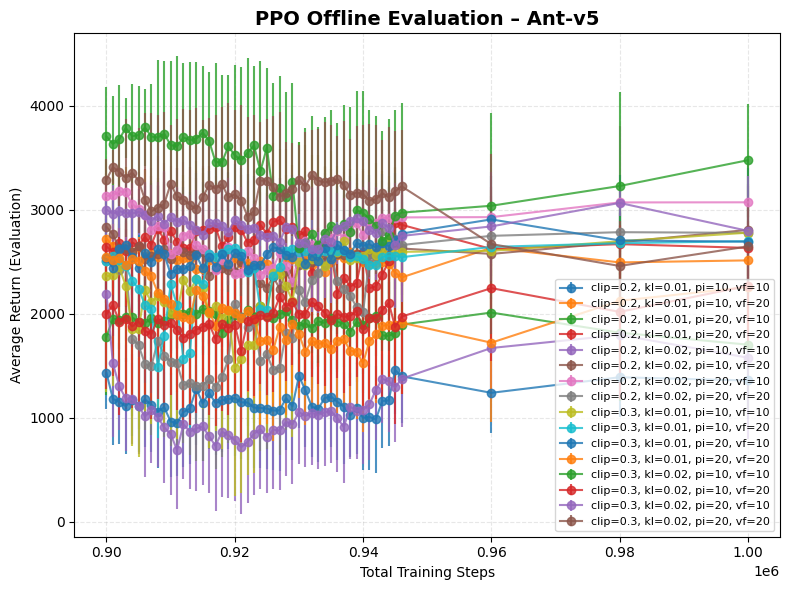

In [2]:
df_eval, eval_summary = analyze_ppo_offline_evals(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_chet",
    env_name="Ant-v5",
    save_fig=True
)


In [4]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

# ============================================================
# 🔧 Utility Functions
# ============================================================

def extract_ppo_params(fn: str):
    """Extract PPO parameters from filename for legend labels."""
    c = re.search(r"clip_param=([\d\.]+)", fn)
    kl = re.search(r"target_kl=([\d\.]+)", fn)
    pi = re.search(r"train_policy_iters=(\d+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    return f"clip={c.group(1) if c else '?'}, kl={kl.group(1) if kl else '?'}, pi={pi.group(1) if pi else '?'}, vf={vf.group(1) if vf else '?'}"


def tol_interval(arr2d: np.ndarray, beta=0.9, alpha=0.05):
    """
    Compute a nonparametric (distribution-free) tolerance interval across multiple seeds.
    Implements the binomial correction step described in the methodology.
    """
    n = arr2d.shape[0]
    if n <= 1:
        # Not enough seeds to compute an interval
        return arr2d[0], arr2d[0]

    # ν: number of samples expected to fall outside the β coverage
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]


# ============================================================
# 📊 Offline Rollout Analysis
# ============================================================

def analyze_offline_rollouts_with_TI(
    log_dir,
    env_name="Unknown Environment",
    beta=0.9,
    alpha=0.05,
    save_fig=False
):
    """
    Perform offline rollout analysis with distribution-free tolerance intervals (TIs).
    
    Parameters
    ----------
    log_dir : str or Path
        Directory containing log files (.json/.jso).
    env_name : str
        Environment name (e.g. "Ant-v5").
    beta : float
        Desired coverage proportion (e.g. 0.9 means capture 90% of population).
    alpha : float
        Significance level for confidence (e.g. 0.05 means 95% confidence).
    save_fig : bool
        If True, saves the figure as PNG.
    """

    # --- Load files ---
    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} log files in {folder}")
    if not files:
        raise FileNotFoundError("No log files found!")

    cfg_groups = defaultdict(list)

    for fpath in files:
        try:
            with fpath.open("r") as f:
                data = json.load(f)

            # Extract evaluation events only
            evals = [e for e in data.get("events", []) if e.get("event") == "evaluation"]
            if not evals:
                continue

            steps = np.array([e.get("total_steps", np.nan) for e in evals])
            avg_returns = np.array([e.get("average_return", np.nan) for e in evals])

            cfg = re.sub(r"_seed=\d+", "", fpath.name)
            cfg_groups[cfg].append(pd.DataFrame({"steps": steps, "avg": avg_returns}))

        except Exception as e:
            print(f"⚠️ {fpath.name}: {e}")

    print(f"Found {len(cfg_groups)} unique algorithm configs with offline rollouts.\n")

    # ============================================================
    # 🔢 Aggregate Across Seeds per Configuration
    # ============================================================
    results = {}
    for cfg, dfs in cfg_groups.items():
        if len(dfs) == 0:
            continue
        # Concatenate all seeds for this config
        combined = pd.concat(dfs, ignore_index=True)
        combined = combined.sort_values("steps")

        # Determine common grid (interpolate across seeds)
        unique_steps = np.unique(combined["steps"])
        all_seeds = []

        for df in dfs:
            interp = np.interp(unique_steps, df["steps"], df["avg"], left=np.nan, right=np.nan)
            all_seeds.append(interp)

        all_seeds = np.array(all_seeds)

        # Compute mean and distribution-free tolerance interval
        mean_curve = np.nanmean(all_seeds, axis=0)
        low, up = tol_interval(all_seeds, beta=beta, alpha=alpha)

        results[cfg] = dict(steps=unique_steps, mean=mean_curve, low=low, up=up)

    # ============================================================
    # 📈 Visualization
    # ============================================================
    plt.figure(figsize=(10, 6))
    for i, (cfg, data) in enumerate(results.items()):
        color = f"C{i%10}"
        label = extract_ppo_params(cfg)
        plt.plot(data["steps"], data["mean"], color=color, lw=1.8, label=label)
        plt.fill_between(data["steps"], data["low"], data["up"], color=color, alpha=0.15)

    plt.title(
        f"Offline Rollout Performance with Tolerance Intervals\n{env_name}",
        fontsize=14,
        weight="bold"
    )
    plt.xlabel("Training Steps")
    plt.ylabel("Average Offline Return")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend(fontsize=8, frameon=False)
    plt.tight_layout()

    if save_fig:
        out_path = folder / f"Offline_TI_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()

    return results

Found 32 log files in \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_chet
Found 16 unique algorithm configs with offline rollouts.

💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_chet\Offline_TI_Halfcheeta_(Offline_Evaluation).png


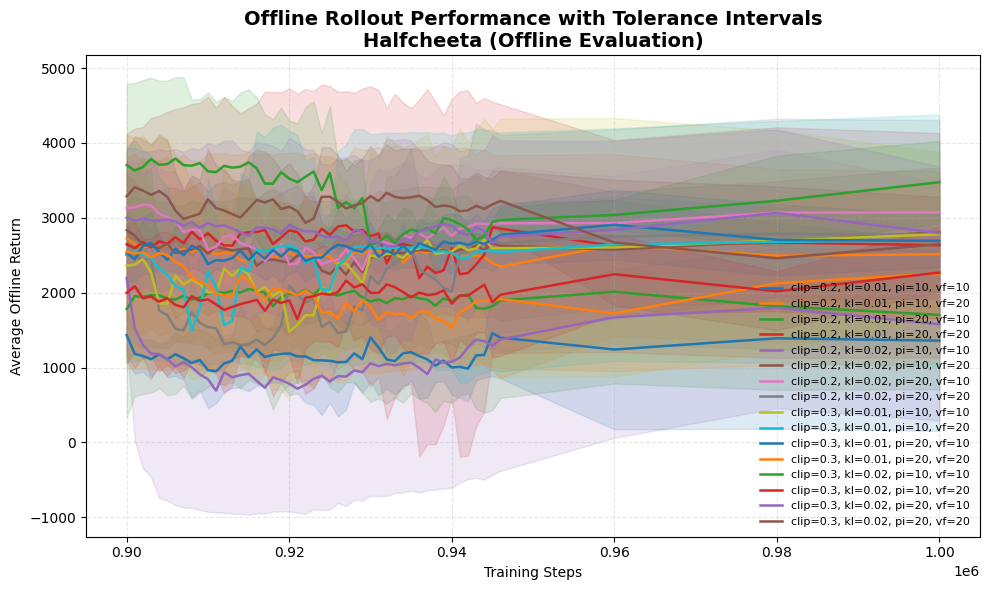

In [5]:
# ============================================================
# 🚀 Example Usage
# ============================================================

if __name__ == "__main__":
    analyze_offline_rollouts_with_TI(
        log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_chet",
        env_name="Halfcheeta (Offline Evaluation)",
        beta=0.9,  # coverage (90%)
        alpha=0.05,  # 95% confidence
        save_fig=True
    )
